# MODNet 'matbench_phonons' benchmarking

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "3"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [2]:
Markdown(filename="./README.md")

# matbench_phonons

## Introduction

- Predicting the largest phonon PhDOS peak for 1265 structures from DFPT dataset.

Results to beat:

| Method | PhDOS peak (1/cm) |
|:-------|------------------:|
| AM     |             50.8  |
| MEGNet |             36.9  |
| CGCNN  |             57.8  |
| RF     |             68.0  |

## To-do

- [x] Featurize
- [x] Feature selection (extremely slow, >months...)
- [x] Baseline MODNet model (~45 1/cm)

## Notes

- Very slow to do feature selection; need to do sampling

## Results

| Method/architecture | PhDOS peak (1/cm) |
|:--------------------|------------------:|
| MODNet baseline ([64, 64, 8, 8], 175 features) |   38.7 |


## Data exploration

In [3]:
df = load_dataset("matbench_phonons")

In [4]:
df.columns

Index(['structure', 'last phdos peak'], dtype='object')

### Target space

In [5]:
df.describe()

,last phdos peak
count,1265.000000
mean,581.351504
std,494.086962
min,59.585774
25%,270.585758
50%,461.585742
75%,689.585724
max,3643.743437


Text(0.5, 0, 'Last PhDOS peak')

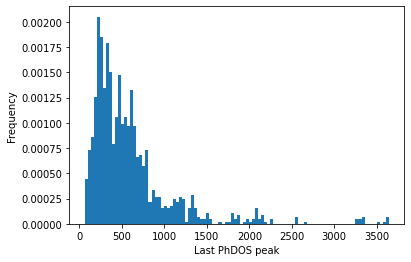

In [6]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["last phdos peak"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Last PhDOS peak")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [7]:
PRECOMPUTED_MODDATA = "./precomputed/phonon_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["last phdos peak"].tolist(), 
        target_names=["last phdos peak"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.feature_selection(n=-1)
    data.save(PRECOMPUTED_MODDATA)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7ffe69bdef70> object, created with modnet version 0.1.8~develop


In [8]:
#data.optimal_features=None
#data.cross_nmi = None
#data.num_classes = {"w":0}
#data.feature_selection(n=-1)
#data.save("./precomputed/phonon_benchmark_moddata_MPCNMI.pkl.gz")

## Training

In [9]:
try:
    plot_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import *
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets.rename(columns={data.target_names[0]: "w"}, inplace=True)

# [[512], [128], [32], [16]]
best_settings = {
    "increase_bs":True,
    "num_neurons": [[512], [128], [64], [64]],
    "n_feat": 280,
    "lr": 0.005,
    "epochs": 800,
    "act": "elu",
    "batch_size": 64,
    "loss": "mae",
}

results = matbench_benchmark(data, [[["w"]]], {"w": 1}, best_settings,save_folds=True)
np.mean(results['scores'])

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: MAE = 38.29470598536493


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: MAE = 33.155249547489355


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: MAE = 34.94839364983732


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: MAE = 31.131126646525168


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #5: MAE = 34.112118691620346


34.328318904167425

In [10]:
best_settings = {
    "increase_bs":True,
    "num_neurons": [[512], [128], [64], [64]],
    "n_feat": 280,
    "lr": 0.005,
    "epochs": 800,
    "act": "elu",
    "batch_size": 64,
    "loss": "mae",
}

NameError: name 'sns' is not defined

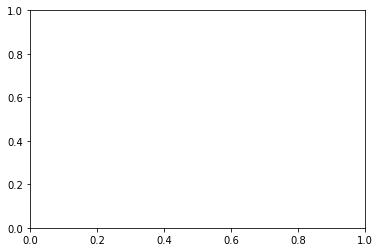

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", ax=ax, alpha=0.5)
sns.regplot(data=reg_df, x="targets", y="predictions", ax=ax, scatter=False)
plt.xlabel("True")
plt.ylabel("Pred.")

In [ ]:
g = sns.jointplot(data=reg_df, x="errors", y="predictions", hue="split", palette="Dark2", alpha=0.0, marginal_kws={"shade": False})
g.plot_joint(sns.scatterplot, hue=None, c="black", s=5, alpha=0.8)
g.plot_joint(sns.kdeplot, color="split", zorder=0, levels=5, alpha=0.5)

In [ ]:
sns.kdeplot(data=reg_df, x="targets", y="predictions", hue="split", shade=False, levels=3, palette="Dark2", alpha=0.5, )